# YOLOv3 training based on Repo ultralytics/yolov3

> References:
- https://github.com/ultralytics/yolov3

What I would do in this Jupyter Notebook:
![](./images/yolov3-training.png)

我实现了前两部，但是VSCODE我反复`Ctrl+S`竟然没保存？？？中途Git提交代码了也没有保存进度？？？反正代码很简单，就是将ego-hand训练集前16张图片单独取出来做出新的数据集，也是训练集和验证集，所以data里面train和valid指向一样的txt，names文件都一样。

然后重新设置了两个YOLOv3的model cfg文件（直接从`yolov3-1cls.cfg`修改）：

- `yolov3-hand.cfg`：保证yolo层classes=1，前一个conv层filters=18
- `yolov3-hand-anchors.cfg`：除了上面一个cfg的内容，将yolo层的anchors修改为自己计算的。

另外加上了几句训练的语句，反正本地也没跑出来，明天直接上Colab跑。

这反复保存还没保存一定是bug！还好代码比较简单，这次就不重写了。

## Small dataset: hand64

https://colab.research.google.com/drive/1Oe6opsYZwAhIL04AD4o-OCHo-C2n-M7N?usp=sharing

训练结果

![](https://user-images.githubusercontent.com/45664104/86968130-8f667100-c163-11ea-88d7-f84634e965ba.png)

测试结果
Ground truth
![test_batch0_gt](https://user-images.githubusercontent.com/45664104/87094059-23a10880-c236-11ea-99a3-a42dd1c36cef.jpg)

Prediction
![test_batch0_pred](https://user-images.githubusercontent.com/45664104/87094064-256acc00-c236-11ea-9214-b10315370c0f.jpg)


训练发生了很大的问题：训练效果很差，precisi和recall都是0，mAP保持在0.02以下，所以我现在想看一下是哪里导致了这些问题

- 检查数据集标注有没有问题
- 查看issues看类似问题的思路
- 模型配置文件是不是错了
- 数据集是不是太小了
- 学习速率是不是太小了

### 检查数据集

In [1]:
PATH = '../datasets/hand64'

In [2]:
import sys
sys.path.append('yolov3')

In [3]:
import os
import glob

In [4]:
from utils.utils import plot_one_box, xywh2xyxy

In [5]:
# 检查标注名称和位置是否都正确

# Get all image paths and related annotations

# classes
classes = []
with open(os.path.join(PATH, 'classes.names'), 'r') as f:
    for line in f:
        classes.append(line[:-1])

# image lists
img_paths = []
with open(os.path.join(PATH, 'train.txt'), 'r') as f:
    for line in f:
        img_paths.append(line[:-1])

# annotation lists
anns = []
for img_path in img_paths:
    img_base_name = os.path.basename(img_path)
    ann_path = os.path.join(PATH, 'labels', img_base_name[:-3] + 'txt')
    ann = []
    with open(ann_path, 'r') as f:
        for line in f:
            line = line[:-1]    # Strip '\n'
            line = line.split()
            ann.append(line)
    anns.append(ann)

In [40]:
# Get one sample
image_path = img_paths[0]
ann = anns[0][0]

# attributes
import numpy as np 
import random
import cv2

image = cv2.imread(image_path)
colors = [[random.randint(0, 255) for _ in range(3)] for _ in range(len(classes))]
label = '%s' % (classes[int(ann[0])])
xywh = [float(i) for i in ann[1:]]

xyxy = [0]*4

xyxy[0] = xywh[0] - xywh[2] / 2  # top left x
xyxy[1] = xywh[1] - xywh[3] / 2  # top left y
xyxy[2] = xywh[0] + xywh[2] / 2  # bottom right x
xyxy[3] = xywh[1] + xywh[3] / 2  # bottom right y

In [41]:
xywh

[0.596354, 0.571296, 0.129167, 0.301852]

In [42]:
image.shape

(1080, 1920, 3)

In [43]:
xyxy

[0.5317705, 0.42037, 0.6609375000000001, 0.722222]

In [44]:
xyxy[0] *= image.shape[1]
xyxy[1] *= image.shape[0]
xyxy[2] *= image.shape[1]
xyxy[3] *= image.shape[0]

In [45]:
plot_one_box(xyxy, image, label=label, color=colors[int(ann[0])])
save_path = os.path.join('./images', os.path.basename(image_path)[:-4]+'_write.jpg')
cv2.imwrite(save_path, image)

True

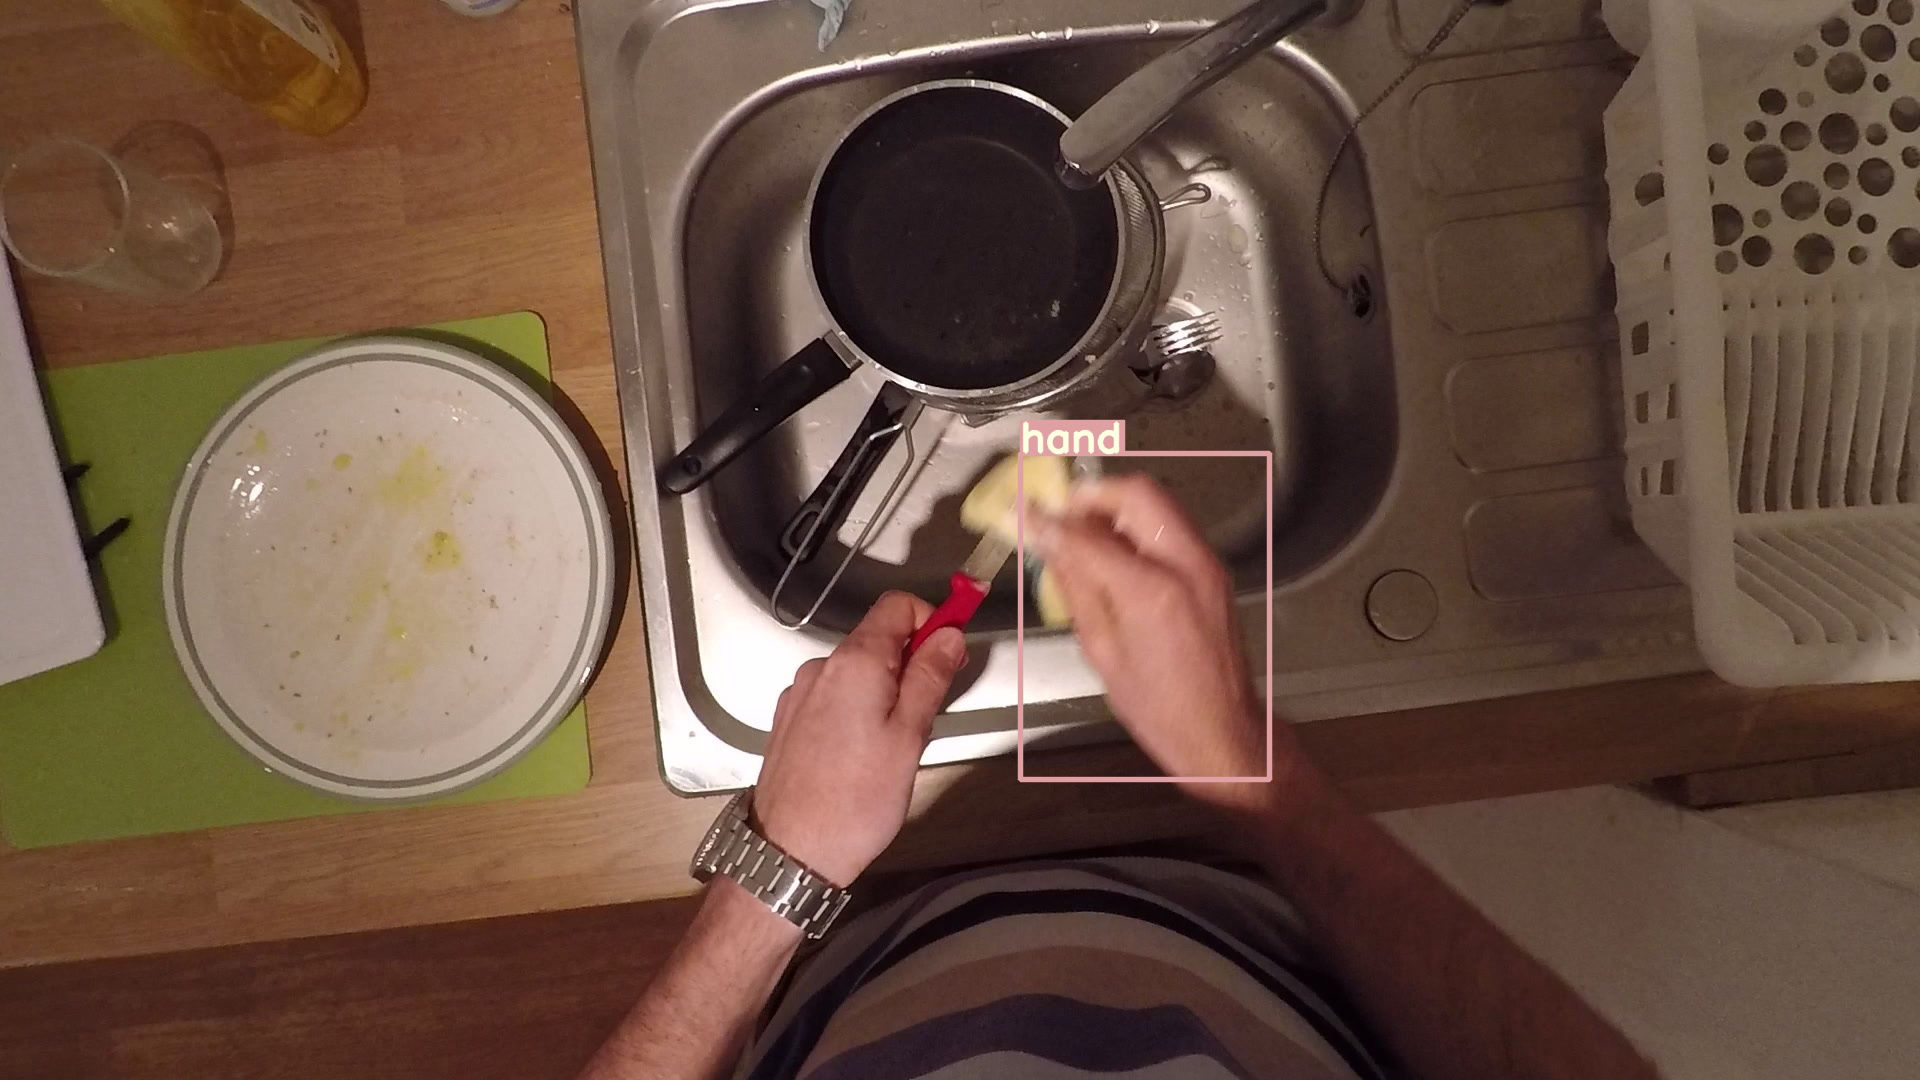

In [46]:
from PIL import Image
im = Image.open(save_path)
im

差得不多，再检查一下标注。

重新自己用一个专门的[yolov3标注工具](https://github.com/developer0hye/Yolo_Label)标注了一张图片，显示标注差不多，说明数据集应该没问题：

![image](https://user-images.githubusercontent.com/45664104/87072216-538ae480-c213-11ea-8479-1df7894840cf.png)


## 检查issues

现在检查一下issue里面有没有提示吧，看前人有没有类似的问题。

https://github.com/ultralytics/yolov3/issues/898#issuecomment-623174650

- 更多图片
- 输入size


先检查一下cfg文件，发现没什么问题，都是按照规范改的。不过试试默认的cfg，
就发现结果更烂，mAP一直为0。
![download](https://user-images.githubusercontent.com/45664104/87096459-cc516700-c23a-11ea-97ff-1dcf5a1f2279.png)


> 为什么看mAP？
https://github.com/ultralytics/yolov3/issues/1252#issuecomment-635795279

然后试试更大的学习速率。在cfg文件里把它改成0.01（原本是0.001）。没有太大改进。

![download (1)](https://user-images.githubusercontent.com/45664104/87098448-379d3800-c23f-11ea-9340-f198b5408667.png)


In [1]:
# 在BlueCrystal Phase 4上训练yolov3模型

In [1]:
# 此处代码均为命令行命令

```shell
git clone https://github.com/ultralytics/yolov3
cd yolov3

```

Full dataset: ego-hand